In [57]:
import keras
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator

In [58]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [59]:
import os
def plot_imgs(directory, top=10):
    all_item_dirs = os.listdir(directory)
    item_files = [os.path.join(directory, file) for file in all_item_dirs][:5]
  
    plt.figure(figsize=(20, 20))
  
    for i, img_path in enumerate(item_files):
        plt.subplot(10, 10, i+1)
    
        img = plt.imread(img_path)
        plt.tight_layout()         
        plt.imshow(img, cmap='gray') 

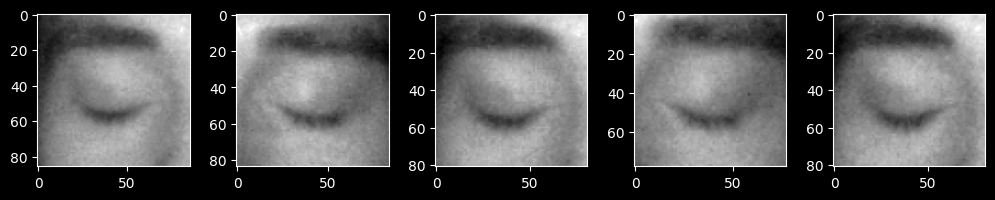

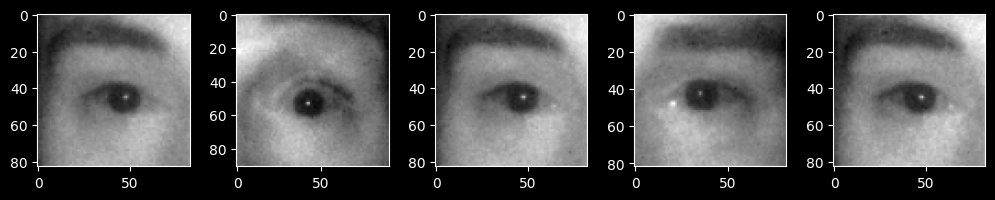

In [60]:
data_path = 'dataset/train'

directories = ['/Closed_Eyes', '/Open_Eyes']

for j in directories:
    plot_imgs(data_path+j)

In [61]:
batch_size = 32
train_datagen = ImageDataGenerator(horizontal_flip = True, 
                                  rescale = 1./255, 
                                  zoom_range = 0.2, 
                                  validation_split = 0.1)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [62]:
train_data_path = 'dataset/train'
test_data_path = 'dataset/test'

train_set = train_datagen.flow_from_directory(train_data_path, target_size = (64,64),
                                              batch_size = batch_size, 
                                              color_mode = 'grayscale',
                                              class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_data_path, target_size = (64,64),
                                              batch_size = batch_size, 
                                              color_mode = 'grayscale',
                                              class_mode = 'categorical')

Found 3400 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


In [63]:
classes = 2

model = Sequential()
model.add(Conv2D(32, (3,3), padding = 'same', input_shape = (64,64,1), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(64, (3,3), padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(128,(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2))) 

model.add(Flatten())

model.add(Dense(64, activation = 'relu'))

model.add(Dense(classes, activation = 'softmax'))

print(model.summary())



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 8, 8, 128)        

In [64]:
model.compile(loss = 'categorical_crossentropy',optimizer = 'adam' , metrics = ['accuracy'])

In [65]:
model_path="yawn_detection.h5"

checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', verbose=1, 
                              save_best_only=True, mode='max')

callbacks_list = [checkpoint]

In [66]:
num_epochs = 3
training_steps=train_set.n//train_set.batch_size
validation_steps =test_set.n//test_set.batch_size

In [67]:
history = model.fit_generator(train_set, epochs=num_epochs, steps_per_epoch=training_steps,validation_data=test_set,
                    validation_steps=validation_steps, callbacks = callbacks_list)

C:\Users\asus\AppData\Local\Temp\ipykernel_16568\2180583923.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_set, epochs=num_epochs, steps_per_epoch=training_steps,validation_data=test_set,


Epoch 1/3


106/106 [==============================] - ETA: 0s - loss: 0.2831 - accuracy: 0.8759
Epoch 1: val_accuracy improved from -inf to 0.98958, saving model to yawn_detection.h5
106/106 [==============================] - 19s 162ms/step - loss: 0.2831 - accuracy: 0.8759 - val_loss: 0.0240 - val_accuracy: 0.9896
Epoch 2/3


C:\Users\asus\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


106/106 [==============================] - ETA: 0s - loss: 0.0437 - accuracy: 0.9860
Epoch 2: val_accuracy improved from 0.98958 to 0.99826, saving model to yawn_detection.h5
106/106 [==============================] - 13s 123ms/step - loss: 0.0437 - accuracy: 0.9860 - val_loss: 0.0053 - val_accuracy: 0.9983
Epoch 3/3
106/106 [==============================] - ETA: 0s - loss: 0.0432 - accuracy: 0.9852
Epoch 3: val_accuracy did not improve from 0.99826
106/106 [==============================] - 11s 104ms/step - loss: 0.0432 - accuracy: 0.9852 - val_loss: 0.0113 - val_accuracy: 0.9965


In [75]:
import cv2
import numpy as np
from keras.models import load_model

# Charger le modèle entraîné
model = load_model('yawn_detection.h5')  # Assurez-vous que le chemin est correct

# Définir les classes
classes = {0: 'Closed', 1: 'Open'}

# Charger les classificateurs en cascade Haar pour la détection de visage et des yeux
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

# Fonction pour détecter l'état des yeux dans une région d'intérêt (ROI)
def detect_eye_state(roi_gray, roi_color):
    # Détecter les yeux dans la région d'intérêt
    eyes = eye_cascade.detectMultiScale(roi_gray)
    
    # Pour chaque œil détecté, dessiner un rectangle autour de lui
    for (ex, ey, ew, eh) in eyes:
        cv2.rectangle(roi_color, (ex, ey), (ex+ew, ey+eh), (0, 255, 0), 2)
    
    # Si aucun œil n'est détecté, l'état est considéré comme fermé
    if len(eyes) == 0:
        return "Closed"
    else:
        return "Open"

# Capturer la vidéo en temps réel depuis la caméra
cap = cv2.VideoCapture(0)

while True:
    # Lire une frame de la vidéo
    ret, frame = cap.read()
    if not ret:
        break
    
    # Convertir l'image en niveaux de gris
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Détecter les visages dans l'image
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)
    
    # Pour chaque visage détecté, appliquer la détection des yeux
    for (x, y, w, h) in faces:
        # Dessiner un rectangle autour du visage détecté
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
        
        # Extraire la région d'intérêt (ROI) pour les yeux
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = frame[y:y+h, x:x+w]
        
        # Appliquer la détection d'état des yeux sur la région d'intérêt
        eye_state = detect_eye_state(roi_gray, roi_color)
        
        # Afficher l'état des yeux sur le visage détecté
        cv2.putText(frame, "Eye State: {}".format(eye_state), (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
    
    # Afficher la frame
    cv2.imshow('Eye State Detection', frame)
    
    # Quitter la boucle si la touche 'q' est enfoncée
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Libérer les ressources
cap.release()
cv2.destroyAllWindows()


KeyboardInterrupt: 

In [76]:
cap.release()
cv2.destroyAllWindows()